Sentiment Classification of Tweets

This code trains the classifier with data from Train.csv

The model which outputs the Test.csv predictions

[[119 178  98]
 [159 749 300]
 [ 24 252 302]]
Accuracy:0.5364511691884457


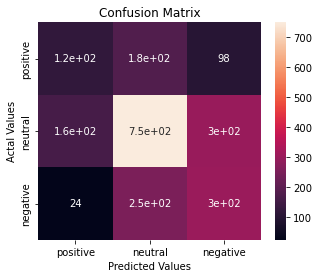

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer

#This part is for the helper functions to create our model
def cleanText_1(text):
    text = re.sub('@[A-Za-z0-9]+', '',text)
    text = re.sub('#', '',text)
    text = re.sub('RT[\s]+', '',text)
    result = re.sub('https?:\/\/\S+', '',text)
    return result


#This function calculates the conditional probabilities for all the features
#Without using any smothing
def get_cond_prob_1(counts, words):
    n = counts.sum()
    vocab = len(words)
    prob_dict = defaultdict(lambda : 1)
    for i in range(len(words)):
        prob_dict.update({words[i]: (counts[i])/(n)})
    return prob_dict

#This function trains our model
#Navie Bayes classifier is used to predict the sentiments
def train_1(feature_vector, feature_labels):
    # For this classifier we are working with three labels 
    c1 = "positive"
    c2 = "neutral"
    c3 = "negative"
    
    
    # The label class prior probabilities are calculated
    prior_prob = pd.DataFrame(feature_labels, columns = ['labels'])['labels'].value_counts(normalize=True).to_dict()
    
    #The arrays stores instances of their respected class labels
    positive = []
    neutral = []
    negative = []
    for i in range(len(feature_vector)):
        if feature_labels[i] == 'positive':
            positive.append(feature_vector[i])
        elif feature_labels[i] == 'neutral':
            neutral.append(feature_vector[i])
        else:
            negative.append(feature_vector[i])
            
    #This part computes the frequency of each word in their respected class        
    positive = np.array(positive).sum(axis=0)
    neutral = np.array(neutral).sum(axis=0)
    negative = np.array(negative).sum(axis=0)
    
    #The conditional probabilities of each feature is calculated
    c1_conditional_prob = get_cond_prob_1(positive, features)
    c2_conditional_prob = get_cond_prob_1(neutral, features)
    c3_conditional_prob = get_cond_prob_1(negative, features)
    
    # The label class prior probabilities are stored in both conditional probabilities
    c1_conditional_prob.update(prior_prob)
    c2_conditional_prob.update(prior_prob)
    c3_conditional_prob.update(prior_prob)

    return c1_conditional_prob, c2_conditional_prob, c3_conditional_prob

# This function should predict classes for new items in the testing data
def predict_1(test_set, label_1_prob, label_2_prob, label_3_prob, features):
    # For this classifier we are working with three labels 
    c1 = "positive"
    c2 = "neutral"
    c3 = "negative"
    
    # label stores the predicted class label for every row
    # The index of the row is coherant in both arrays
    labels = []
    for i in range(len(test_set)):
        prob = []
        row = test_set[i]
        c1_prob = label_1_prob[c1]
        c2_prob = label_2_prob[c2]
        c3_prob = label_3_prob[c3]
        for j in range(len(features)):
            #If the word exists in the tweet its conditional probability is multiplied
            #According to the formula of Naive Bayes
            if row[j] != 0:
                c1_prob *= label_1_prob[features[j]]
                c2_prob *= label_2_prob[features[j]]
                c3_prob *= label_3_prob[features[j]]
        prob.append(c1_prob)
        prob.append(c2_prob)
        prob.append(c3_prob)
        prob_max = max(prob)
        # Whichever prob is higher is taken to the label 
        # Because the formula requires us to take the max value
        # Then the label is stored for that row in the label array
        if c1_prob==prob_max:
            labels.append(c1)
        elif c3_prob==prob_max:
            labels.append(c3)
        else:
            labels.append(c2)
    return labels



#This part is the code which tests the "Test.csv" and predicts their sentiment

#The train data and the test data is extracted from the csv
data = pd.read_csv('Train.csv', sep=',')
train_data, test_data = train_test_split(data, test_size=0.1, shuffle = False)

#Then we separate the tweet text and the label (sentiment). 
#separating instance and label for Train
X_train_raw = pd.Series([x[0] for x in train_data[['text']].values])
X_train_raw = X_train_raw.apply(cleanText)
Y_train = [x[0] for x in train_data[['sentiment']].values]

#separating instance and label for Test
X_test_raw = pd.Series([x[0] for x in test_data[['text']].values])
X_test_raw = X_test_raw.apply(cleanText)


#We use the CountVectorizer library to separate all the words in the Train corpus (dataset)
#These words are then used as the 'vectors' or 'features' to represent each instance (Tweet)
BoW_vectorizer = CountVectorizer()

#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW = BoW_vectorizer.fit_transform(X_train_raw)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_BoW = BoW_vectorizer.transform(X_test_raw)

#The features are put in a vector
train_vector = np.array(X_train_BoW.toarray())
test_vector = np.array(X_test_BoW.toarray())

#Features stores all the words used in the train csv
features = BoW_vectorizer.get_feature_names()

#This three variables store the trained data for each label to make the prediction
c1_probs, c2_probs, c3_probs = train_1(train_vector, Y_train)

#The predictions are stored in the variable as a list
result = predict_1(test_vector, c1_probs, c2_probs, c3_probs, features)
#The ground truth is stored for the test data
actual = [x[0] for x in test_data[['sentiment']].values]
cm = confusion_matrix(actual, result)
print(cm)
acc = accuracy_score(actual, result)
print("Accuracy:" + str(acc))
cm_df = pd.DataFrame(cm,
                     index = ['positive','neutral','negative'], 
                     columns = ['positive','neutral','negative'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


## In this model lapse smoothing method was used 
Everything else was kept constant


In [ ]:
#This part is for the helper functions to create our model
def cleanText_2(text):
    text = re.sub('@[A-Za-z0-9]+', '',text)
    text = re.sub('#', '',text)
    text = re.sub('RT[\s]+', '',text)
    result = re.sub('https?:\/\/\S+', '',text)
    return result


#This function calculates the conditional probabilities for all the features
#Without using any smothing
def get_cond_prob_2(counts, words):
    n = counts.sum()
    vocab = len(words)
    prob_dict = defaultdict(lambda : 1)
    for i in range(len(words)):
        prob_dict.update({words[i]: (counts[i] + 1 )/(n + vocab)})
    return prob_dict

#This function trains our model
#Navie Bayes classifier is used to predict the sentiments
def train_2(feature_vector, feature_labels):
    # For this classifier we are working with three labels 
    c1 = "positive"
    c2 = "neutral"
    c3 = "negative"
    
    
    # The label class prior probabilities are calculated
    prior_prob = pd.DataFrame(feature_labels, columns = ['labels'])['labels'].value_counts(normalize=True).to_dict()
    
    #The arrays stores instances of their respected class labels
    positive = []
    neutral = []
    negative = []
    for i in range(len(feature_vector)):
        if feature_labels[i] == 'positive':
            positive.append(feature_vector[i])
        elif feature_labels[i] == 'neutral':
            neutral.append(feature_vector[i])
        else:
            negative.append(feature_vector[i])
            
    #This part computes the frequency of each word in their respected class        
    positive = np.array(positive).sum(axis=0)
    neutral = np.array(neutral).sum(axis=0)
    negative = np.array(negative).sum(axis=0)
    
    #The conditional probabilities of each feature is calculated
    c1_conditional_prob = get_cond_prob_2(positive, features)
    c2_conditional_prob = get_cond_prob_2(neutral, features)
    c3_conditional_prob = get_cond_prob_2(negative, features)
    
    # The label class prior probabilities are stored in both conditional probabilities
    c1_conditional_prob.update(prior_prob)
    c2_conditional_prob.update(prior_prob)
    c3_conditional_prob.update(prior_prob)

    return c1_conditional_prob, c2_conditional_prob, c3_conditional_prob

# This function should predict classes for new items in the testing data
def predict_2(test_set, label_1_prob, label_2_prob, label_3_prob, features):
    # For this classifier we are working with three labels 
    c1 = "positive"
    c2 = "neutral"
    c3 = "negative"
    
    # label stores the predicted class label for every row
    # The index of the row is coherant in both arrays
    labels = []
    for i in range(len(test_set)):
        prob = []
        row = test_set[i]
        c1_prob = label_1_prob[c1]
        c2_prob = label_2_prob[c2]
        c3_prob = label_3_prob[c3]
        for j in range(len(features)):
            #If the word exists in the tweet its conditional probability is multiplied
            #According to the formula of Naive Bayes
            if row[j] != 0:
                c1_prob *= label_1_prob[features[j]]
                c2_prob *= label_2_prob[features[j]]
                c3_prob *= label_3_prob[features[j]]
        prob.append(c1_prob)
        prob.append(c2_prob)
        prob.append(c3_prob)
        prob_max = max(prob)
        # Whichever prob is higher is taken to the label 
        # Because the formula requires us to take the max value
        # Then the label is stored for that row in the label array
        if c1_prob==prob_max:
            labels.append(c1)
        elif c3_prob==prob_max:
            labels.append(c3)
        else:
            labels.append(c2)
    return labels



#This part is the code which tests the "Test.csv" and predicts their sentiment

#The train data and the test data is extracted from the csv
data = pd.read_csv('Train.csv', sep=',')
train_data, test_data = train_test_split(data, test_size=0.1, shuffle = False)

#Then we separate the tweet text and the label (sentiment). 
#separating instance and label for Train
X_train_raw = pd.Series([x[0] for x in train_data[['text']].values])
X_train_raw = X_train_raw.apply(cleanText)
Y_train = [x[0] for x in train_data[['sentiment']].values]

#separating instance and label for Test
X_test_raw = pd.Series([x[0] for x in test_data[['text']].values])
X_test_raw = X_test_raw.apply(cleanText)


#We use the CountVectorizer library to separate all the words in the Train corpus (dataset)
#These words are then used as the 'vectors' or 'features' to represent each instance (Tweet)
BoW_vectorizer = CountVectorizer()

#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW = BoW_vectorizer.fit_transform(X_train_raw)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_BoW = BoW_vectorizer.transform(X_test_raw)

#The features are put in a vector
train_vector = np.array(X_train_BoW.toarray())
test_vector = np.array(X_test_BoW.toarray())

#Features stores all the words used in the train csv
features = BoW_vectorizer.get_feature_names()

#This three variables store the trained data for each label to make the prediction
c1_probs, c2_probs, c3_probs = train_2(train_vector, Y_train)

#The predictions are stored in the variable as a list
result = predict_2(test_vector, c1_probs, c2_probs, c3_probs, features)
cm = confusion_matrix(actual, result)
print(cm)
#The ground truth is stored for the test data
actual = [x[0] for x in test_data[['sentiment']].values]
acc = accuracy_score(actual, result)
print("Accuracy:" + str(acc))
cm_df = pd.DataFrame(cm,
                     index = ['positive','neutral','negative'], 
                     columns = ['positive','neutral','negative'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


## In this model Stop words were removed
Everything else was kept constant


In [ ]:
#This part is for the helper functions to create our model
def cleanText_3(text):
    text = re.sub('@[A-Za-z0-9]+', '',text)
    text = re.sub('#', '',text)
    text = re.sub('RT[\s]+', '',text)
    result = re.sub('https?:\/\/\S+', '',text)
    stops = [ 'stop', 'the', 'to', 'and', 'a', 'in', 'it', 'is', 'I', 'that', 'had', 'on', 'for', 'were', 'was']
    for words in stops:
        result = re.sub(words, '',result)
    return result


#This function calculates the conditional probabilities for all the features
#Without using any smothing
def get_cond_prob_3(counts, words):
    n = counts.sum()
    vocab = len(words)
    prob_dict = defaultdict(lambda : 1)
    for i in range(len(words)):
        prob_dict.update({words[i]: (counts[i] + 1 )/(n + vocab)})
    return prob_dict

#This function trains our model
#Navie Bayes classifier is used to predict the sentiments
def train_3(feature_vector, feature_labels):
    # For this classifier we are working with three labels 
    c1 = "positive"
    c2 = "neutral"
    c3 = "negative"
    
    
    # The label class prior probabilities are calculated
    prior_prob = pd.DataFrame(feature_labels, columns = ['labels'])['labels'].value_counts(normalize=True).to_dict()
    
    #The arrays stores instances of their respected class labels
    positive = []
    neutral = []
    negative = []
    for i in range(len(feature_vector)):
        if feature_labels[i] == 'positive':
            positive.append(feature_vector[i])
        elif feature_labels[i] == 'neutral':
            neutral.append(feature_vector[i])
        else:
            negative.append(feature_vector[i])
            
    #This part computes the frequency of each word in their respected class        
    positive = np.array(positive).sum(axis=0)
    neutral = np.array(neutral).sum(axis=0)
    negative = np.array(negative).sum(axis=0)
    
    #The conditional probabilities of each feature is calculated
    c1_conditional_prob = get_cond_prob_2(positive, features)
    c2_conditional_prob = get_cond_prob_2(neutral, features)
    c3_conditional_prob = get_cond_prob_2(negative, features)
    
    # The label class prior probabilities are stored in both conditional probabilities
    c1_conditional_prob.update(prior_prob)
    c2_conditional_prob.update(prior_prob)
    c3_conditional_prob.update(prior_prob)

    return c1_conditional_prob, c2_conditional_prob, c3_conditional_prob

# This function should predict classes for new items in the testing data
def predict_3(test_set, label_1_prob, label_2_prob, label_3_prob, features):
    # For this classifier we are working with three labels 
    c1 = "positive"
    c2 = "neutral"
    c3 = "negative"
    
    # label stores the predicted class label for every row
    # The index of the row is coherant in both arrays
    labels = []
    for i in range(len(test_set)):
        prob = []
        row = test_set[i]
        c1_prob = label_1_prob[c1]
        c2_prob = label_2_prob[c2]
        c3_prob = label_3_prob[c3]
        for j in range(len(features)):
            #If the word exists in the tweet its conditional probability is multiplied
            #According to the formula of Naive Bayes
            if row[j] != 0:
                c1_prob *= label_1_prob[features[j]]
                c2_prob *= label_2_prob[features[j]]
                c3_prob *= label_3_prob[features[j]]
        prob.append(c1_prob)
        prob.append(c2_prob)
        prob.append(c3_prob)
        prob_max = max(prob)
        # Whichever prob is higher is taken to the label 
        # Because the formula requires us to take the max value
        # Then the label is stored for that row in the label array
        if c1_prob==prob_max:
            labels.append(c1)
        elif c3_prob==prob_max:
            labels.append(c3)
        else:
            labels.append(c2)
    return labels



#This part is the code which tests the "Test.csv" and predicts their sentiment

#The train data and the test data is extracted from the csv
data = pd.read_csv('Train.csv', sep=',')
train_data, test_data = train_test_split(data, test_size=0.1, shuffle = False)

#Then we separate the tweet text and the label (sentiment). 
#separating instance and label for Train
X_train_raw = pd.Series([x[0] for x in train_data[['text']].values])
X_train_raw = X_train_raw.apply(cleanText_3)
Y_train = [x[0] for x in train_data[['sentiment']].values]

#separating instance and label for Test
X_test_raw = pd.Series([x[0] for x in test_data[['text']].values])
X_test_raw = X_test_raw.apply(cleanText_3)


#We use the CountVectorizer library to separate all the words in the Train corpus (dataset)
#These words are then used as the 'vectors' or 'features' to represent each instance (Tweet)
BoW_vectorizer = CountVectorizer()

#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW = BoW_vectorizer.fit_transform(X_train_raw)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_BoW = BoW_vectorizer.transform(X_test_raw)

#The features are put in a vector
train_vector = np.array(X_train_BoW.toarray())
test_vector = np.array(X_test_BoW.toarray())

#Features stores all the words used in the train csv
features = BoW_vectorizer.get_feature_names()

#This three variables store the trained data for each label to make the prediction
c1_probs, c2_probs, c3_probs = train_3(train_vector, Y_train)

#The predictions are stored in the variable as a list
result = predict_3(test_vector, c1_probs, c2_probs, c3_probs, features)
cm = confusion_matrix(actual, result)
print(cm)
#The ground truth is stored for the test data
actual = [x[0] for x in test_data[['sentiment']].values]
acc = accuracy_score(actual, result)
print("Accuracy:" + str(acc))
cm_df = pd.DataFrame(cm,
                     index = ['positive','neutral','negative'], 
                     columns = ['positive','neutral','negative'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()